# Detecting item misfit in Rasch models

Magnus Johansson [](https://orcid.org/0000-0003-1669-592X) (RISE Research Institutes of Sweden, Division Built Environment, System Transition, Centre for Psychiatry Research, Department of Clinical Neuroscience, Karolinska Institutet, & Stockholm Health Care Services, Region Stockholm)  
January 12, 2025

Psychometrics in general have long relied on rule-of-thumb critical values for various goodness of fit metrics. With more powerful personal computers it is both feasible and desirable to use simulation methods to determine appropriate critical cutoff values. This paper illustrates and evaluates the use of an R package for Rasch psychometrics that has implemented functions to simplify the process of determining simulation based cutoff values. Through a series of simulation studies, a comparison is made between the two methods of information-weighted conditional item fit (“infit”) and item-restscore correlations using Goodman and Kruskal’s $\gamma$. Results indicate the limitations of small samples (n \< 500) in correctly detecting item misfit due to multidimensionality, especially when a larger proportion of items are misfit. Item outfit shows very low performance in general. Conditional infit with simulation-based cutoffs performs better than item-restscore with sample sizes below 500. Both methods result in problematic rates of false positives with large samples (n \>= 1000). Large datasets should be analyzed using nonparametric bootstrap of subsamples with item-restscore to reduce the risk of type-1 errors. Finally, the importance of an iterative analysis process is emphasized, since a situation where several items show underfit will cause other items to show overfit to the Rasch model. Underfit items should be removed one at a time, and a re-analysis conducted for each step to avoid erroneously eliminating items.

# 1. Introduction

This paper presents a series of simulations conducted to evaluate methods to detect item misfit due to multidimensionality in Rasch models. First, conditional item infit and outfit ([Müller 2020](#ref-muller_item_2020)) will be under scrutiny. Second, item infit will be compared to the item-restscore method \[Kreiner ([2011](#ref-kreiner_note_2011));christensen_item_2013\]. Third, a bootstrap method for item-restscore will be presented and tested. This paper is intended for a target group of those who make practical use of Rasch analysis and wish to better understand the expected performance of methods available. As such, we refer readers interested in mathematical and statistical descriptions of the methods to referenced papers detailing this aspect. Only two simple performance metrics will be presented in the results: correct detection rate and false positive rate, both in percentages.

The evaluation of item fit under the Rasch model has, in the majority of published psychometric papers, been conducted using various more or less arbitrary rule-of-thumb critical values. Regarding mean squared (MSQ) item residuals, which should ideally be centered around 1.0, there are two sources often cited. One is the book by Bond & Fox ([2015](#ref-bond_applying_2015)), which has garnered around 12 000 citations according to Google Scholar\]. It contains a table with rule-of-thumb recommendations for various settings, ranging from 0.8–1.2 to 0.5–1.7. Another frequently seen source, which is not an actual peer-reviewed publication and thus lacks citation counts, is the webpage at <https://rasch.org/rmt/rmt162f.htm>, where Mike Linacre states 0.5-1.5 to be “productive for measurement”. Neither of these sources seem to rely on simulation studies to support their recommendations. While it is reasonable to accept a non-perfect fit to the Rasch model and also describe what one defines as acceptable levels of misfit, such recommendations would seem less arbitrary if related to simulations showing the range of item fit values found when simulating data that fit the Rasch model.

Müller ([2020](#ref-muller_item_2020)) used simulation to show how the range of critical values for conditional item infit varies with sample size. The expected average conditional item infit range was described by Müller as fairly well captured by Smith’s rule-of-thumb formula 1±2/$\sqrt{n}$ ([R. M. Smith, Schumacker, and Bush 1998](#ref-smith_using_1998)). However, the average range does not apply for all items within a dataset, since item location relative to sample location also affects the model expected item fit. This means that some items within a set of items varying in location are likely to have item fit values outside Smith’s average value range while still fitting the Rasch model. Although primarily affecte by sample size, each item has its variations in the range of expected item fit.

While evaluation of item fit is an essential part of evaluating unidimensionality, it is recommended to use multiple methods. Standardized residuals are frequently analyzed, commonly with principal component analysis (PCA) and an analysis of residual correlations amongst item pairs, often referred to as Yen’s Q3. Chou and Wang ([2010](#ref-chou_checking_2010)) showed that the critical value for PCA of residuals to support unidimensionality suggested by Smith ([2002](#ref-smith_detecting_2002)), using the largest eigenvalue \< 1.5, is not generally applicable since it is affected by both test length and sample size. Christensen and colleagues ([2017](#ref-christensen_critical_2017)) used simulation methods to illustrate the expected range of residual correlations under different conditions. Both of these papers provide important information about the dubiousness of using rule-of-thumb critical values when the empirical distribution of a statistic is not known, but they leave practitioners without tools to determine appropriate cutoffs to apply in practical analysis work.

It is here proposed that by using bootstrapping one can establish item fit critical cutoff values that are relevant for a specific sample and item set. The procedure uses the properties of the available data and simulates multiple new response datasets that fit the Rasch model to determine the range of plausible item fit values for each item. The R package `easyRasch` ([Johansson 2024a](#ref-easyrasch)) includes a function to determine item infit and outfit cutoff values using this method and will be tested in the simulation studies in this paper.

Similar developments, moving from rule-of-thumb towards adaptive critical values, have recently taken place in the related field of confirmatory factor analysis. McNeish and Wolf ([2024](#ref-mcneish_direct_2024)) have created an R package called `dynamic` that uses bootstrapping to determine appropriate critical values for commonly used model fit metrics for models using ordinal or interval data.

It is important to note that the conditional item fit described by Müller ([2020](#ref-muller_item_2020)) and implemented in the `iarm` R package ([Mueller and Santiago 2022](#ref-mueller_iarm_2022)) should not be confused with the unconditional item fit implemented in software such as Winsteps and RUMM2030, as well as all R packages except `iarm`. Unconditional item fit can result in unreliable item fit in sample sizes as small as 200 with an increasing probability of problems as sample size increases. Readers are strongly recommended to read Müller’s paper to fully understand the issues with unconditional item fit. Additionally, the experienced Rasch analyst will perhaps wonder why the Wilson-Hilferty transformed Z statistic (often abbreviated ZSTD), which is based on unconditional MSQ is not included in this analysis. This is also explained in Müller’s paper, where she describes both the notorious problems with sample size and shows that conditional item fit makes ZSTD superfluous. The `easyRasch` package, which is used in this paper, uses the `iarm` implementation of conditional item fit.

Currently, there are no published studies on the performance the item-restscore method, as described by Kreiner and Christensen \[Kreiner ([2011](#ref-kreiner_note_2011));christensen_item_2013\], in detecting misfitting items. Comparing it with an improved version of the long used item infit/outfit methods seemed like a good setting to evaluate item-restscore. The conditional likelihood ratio test ([Andersen 1973](#ref-andersen_goodness_1973)) is included in Study 6, since it is a global test of fit that many are likely to be familiar with. As such, it also serves as a point of reference.

There are six simulation studies included in this paper:

1.  Conditional item infit and outfit
2.  Item-restscore
3.  Comparing infit and item-restscore
4.  Bootstrapped item-restscore
5.  Varying the number of items
6.  Conditional likelihood ratio test

# 2. Methods

In [ ]:
library(iarm)

Loading required package: eRm

Loading required package: ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: formattable
Loading required package: kableExtra

Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

Loading required package: mirt
Loading required package: stats4
Loading required package: lattice

Attaching package: 'mirt'

The following objects are masked from 'package:eRm':

    itemfit, personfit

Loading required package: psych

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

The following object is masked from 'package:eRm':

    sim.rasch

Loading required package: psychotree
Loading required package: partykit
Loading required package: grid
Loading required package: libcoin
Loading required package: mvtnorm
Loading required package: psychotools
Loading required package: matrixStats

Attaching package: 'matrixStats'

The following object is masked from 'package:dplyr':

    count

Loading required package: reshape

Attaching package: 'reshape'

The

Some features are not enabled in this build of Arrow. Run `arrow_info()` for more information.
The repository you retrieved Arrow from did not include all of Arrow's features.
You can install a fully-featured version by running:
`install.packages('arrow', repos = 'https://apache.r-universe.dev')`.

Attaching package: 'arrow'

The following object is masked from 'package:lubridate':

    duration

The following object is masked from 'package:utils':

    timestamp

Loading required package: sysfonts
Loading required package: showtextdb

A fully reproducible manuscript with R code and data is available on GitHub: <https://github.com/pgmj/rasch_itemfit>. Each study included in this paper has its own brief introduction and method section. This is a general description of the methods used.

The simulation of response data used three steps: First, a vector of theta values (person scores on the latent variable’s logit scale) was generated using `rnorm(mean = 0, sd = 1.5)`. Second, a set of item locations ranging from -2 to 2 logits were generated for dichotomous items, using `runif(n = 20, min = -2, max = 2)`. Third, the theta values were used to simulate item responses for participants, using `sim.xdim()` from the `eRm` package ([Mair and Hatzinger 2007](#ref-mair_extended_2007)), which allows the simulation of multidimensional response data. Multiple datasets with 10 000 respondents each were generated using the same item and person parameters, varying the targeting of the misfitting item(s) and number of the misfitting item(s). More details are described in the separate studies. The parametric bootstrapping procedure was implemented using random samples from the simulated datasets. Sample size variations tested are also described in each study.

The general procedure for the parametric bootstrapping is as follows:

1.  Estimation of item locations based on simulated item response data, using conditional maximum likelihood (CML, [Mair and Hatzinger 2007](#ref-mair_extended_2007)).
2.  Estimation of sample theta values using weighted maximum likelihood ([Warm 1989](#ref-warm_weighted_1989)).
3.  Simulation of new response data that fit the Rasch model, using the estimated item locations and theta values.
4.  Estimation of the dichotomous Rasch model for the new response data using CML.
5.  Based on step 4, calculation of conditional item infit and outfit ([Müller 2020](#ref-muller_item_2020); [Mueller and Santiago 2022](#ref-mueller_iarm_2022)) and/or item-restscore metrics ([Kreiner 2011](#ref-kreiner_note_2011); [Mueller and Santiago 2022](#ref-mueller_iarm_2022)).

Steps three and four were iterated over, using resampling with replacement from the estimated theta values as a basis for simulating the response data in step three.

Summary statistics were created with a focus on the percentage of correct detection of misfit and false positives.

A complete list of software used for the analyses is listed in #sec-addmat.

In [ ]:
# read pre-generated item locations for reproducibility
items1 <- read_csv("data/rm_items40.csv") %>%
  slice(1:20) %>% 
  pull(location)

Rows: 40 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): item, location

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
# a matrix to specify which dimension each item loads on
wmat0 <- matrix(nrow = 20,
               ncol = 2)
# set all items to load on dimension one
wmat0[1:20,1] <- 1
wmat0[1:20,2] <- 0
# item 9, with good targeting in this item set (closest to sample theta mean of 0), is chosen to belong to a second dimension
wmat0[9,1] <- 0
wmat0[9,2] <- 1

# a matrix to specify which dimension each item loads on
wmat1 <- matrix(nrow = 20,
               ncol = 2)
wmat1[1:20,1] <- 1
wmat1[1:20,2] <- 0
wmat1[18,1] <- 0
wmat1[18,2] <- 1

# a matrix to specify which dimension each item loads on
wmat2 <- matrix(nrow = 20,
               ncol = 2)
wmat2[1:20,1] <- 1
wmat2[1:20,2] <- 0
wmat2[13,1] <- 0
wmat2[13,2] <- 1

# generate dichotomous data
simdata0 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat0)
simdata1 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat1)
simdata2 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat2)

simdata <- list(data0 = simdata0,
                data1 = simdata1,
                data2 = simdata2)
#saveRDS(simdata,"simdata10000.rds")

### And one dataset with all 3 items misfitting
# a matrix to specify which dimension each item loads on
wmat3 <- matrix(nrow = 20,
               ncol = 2)
# set all items to load on dimension one
wmat3[1:20,1] <- 1
wmat3[1:20,2] <- 0
# item 9, with good targeting in this item set (closest to sample theta mean of 0), is chosen to belong to a second dimension
wmat3[c(9,13,18),1] <- 0
wmat3[c(9,13,18),2] <- 1

# generate dichotomous data
simdata3 <- eRm::sim.xdim(10000, items1, cutpoint = "randomized", Sigma = sigma, weightmat = wmat3)

#saveRDS(simdata3,"data/simdata3.rds")

In [ ]:
# simulate data using 40 items
# read pre-generated item locations for reproducibility
items2 <- read_csv("data/rm_items40.csv") %>%
  pull(location)

# a matrix to specify which dimension each item loads on
wmat4 <- matrix(nrow = 40,
               ncol = 2)
# set all items to load on dimension one
wmat4[1:40,1] <- 1
wmat4[1:40,2] <- 0

wmat4[c(9,13,18),1] <- 0
wmat4[c(9,13,18),2] <- 1

# generate dichotomous data
simdata40items <- eRm::sim.xdim(10000, items2, cutpoint = "randomized", Sigma = sigma, weightmat = wmat4)

# check targeting
#RItargeting(as.data.frame(simdata40items), model = "RM")
#RItargeting(simdata3[,1:10], model = "RM")

#saveRDS(simdata40items,"data/simdata40items.rds")

In [ ]:
simdata <- readRDS("data/simdata10000.rds")

simdata3 <- readRDS("data/simdata3.rds") %>% 
  as.data.frame()

demodata <- simdata[[1]] %>% 
  as.data.frame() %>% 
  slice(1:400) %>% 
  select(V1,V11,V3,V12)

simdata40items <- readRDS("data/simdata40items.rds") %>% 
  as.data.frame()

# 3. Study 1: Item infit and outfit

Item mean square standardized residuals are either unweighted, which is referred to as “outfit”, or information weighted, which we call “infit” ([Ostini and Nering 2006, 86–87](#ref-ostini_polytomous_2006)). For details on conditional item fit we refer to the previously mentioned paper by Müller ([2020](#ref-muller_item_2020)). Conditional item infit and outfit are expected to be near 1, with higher values indicating an item to be underfitting the Rasch model (often due to multidimensionality issues) and lower values indicating overfit.

The function `RIgetfit()` from the `easyRasch` R package is tested here. Its source code can be accessed on GitHub, see #sec-addmat. The function offers the user a choice of the number of bootstrap iterations to use to determine the critical cutoff values for each item’s infit and outfit. Our main interest in this study is two-fold. We want to test variations in the number of iterations used in `RIgetfit()` and evaluate how well the critical values based on the parametric bootstrapping procedure detect misfitting items. Additionally, a comparison between infit and outfit statistics in terms of detection rate and false positive rate will be conducted.

20 dichotomous items are used, with one item misfitting. Item locations are the same throughout all studies unless otherwise noted. The location of the misfitting item relative to the sample theta mean was selected to be approximately 0, -1, and -2 logits. Three separate datasets were generated with these variations, each with 10 000 simulated respondents. One dataset with all three misfitting items was also generated, using the same sample size.

Then the `RIitemfit()` function is used to summarize the bootstrap results and also calculates the infit and outfit for each item in the observed data and highlights items with infit/outfit values outside of the cutoff values. `RIitemfit()` has a default (user-modifiable) setting to slightly truncate the distribution of values using `stats::quantile()` at 0.001 and 0.999 to remove extreme values. An example is demonstrated in <a href="#tbl-itemfit1" class="quarto-xref">Table 1</a>, using a subset of the items used in the simulations. <a href="#fig-itemfit1" class="quarto-xref">Figure 1</a> provides a visualization of the distribution of bootstrapped infit and outfit values, together with the infit/outfit values from the observed data illustrated using an orange diamond shape. Note the variation between items in plausible values of infit and outfit based on the bootstrap, and that Smith’s rule-of-thumb regarding infit (1±2/$\sqrt{n}$) would be 0.9-1.1 for a sample size of 400.

This study was rather computationally demanding since each simulation run entailed 100-400 underlying bootstrap iterations. The sample sizes used were 150, 250, 500, and 1000. The number of iterations to determine cutoff values were 100, 200, and 400. Sample size and iteration conditions were fully crossed with each other and the three different targeting variations of the one misfitting item, resulting in 4*3*3 = 36 conditions. Each combination used 200 simulation runs. The simulations took about 12 hours to run on a Macbook Pro Max M1 using 9 CPU cores.

In [ ]:
simfit <- RIgetfit(demodata, iterations = 400, cpu = 8)
RIitemfit(demodata, simfit, output = "quarto")

In [ ]:
RIgetfitPlot(simfit, demodata, output = "both")

In [ ]:
# define function to run simulations for item infit/outfit cutoff values
itemfitboot <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    # get simulation based cutoff values
    sfit100 <- RIgetfit(data,100,9)
    sfit200 <- RIgetfit(data,200,9)
    sfit400 <- RIgetfit(data,400,9)

    # apply cutoffs and store results
    rfit100 <- RIitemfit(data,sfit100, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 100,
                 iteration = i,
                 samplesize = samplesize)
    
    rfit200 <- RIitemfit(data,sfit200, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 200,
                 iteration = i,
                 samplesize = samplesize)
    
    rfit400 <- RIitemfit(data,sfit400, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 sims = 400,
                 iteration = i,
                 samplesize = samplesize)
    
    # combine output 
    fit <- rbind(rfit100,rfit200,rfit400)
  }
  return(fit)
}

In [ ]:
samplesizes <- c(150,250,500,1000)

ifb0 <- list()
ifb1 <- list()
ifb2 <- list()

#library(tictoc)
#tic()
ifb0 <- map(samplesizes, ~ itemfitboot(simdata[[1]], iterations = 200, samplesize = .x))
#toc() # 14257.358 sec elapsed

ifb1 <- map(samplesizes, ~ itemfitboot(simdata[[2]], iterations = 200, samplesize = .x))
ifb2 <- map(samplesizes, ~ itemfitboot(simdata[[3]], iterations = 200, samplesize = .x))

# saveRDS(ifb0, "data/ifb0_200.rds")
# saveRDS(ifb2, "data/ifb2_200.rds")
# saveRDS(ifb1, "data/ifb1_200.rds")

ifb0_df <- map_dfr(1:4, ~ do.call("rbind", ifb0[[.x]])) %>% 
  add_column(targeting = 0)

ifb1_df <- map_dfr(1:4, ~ do.call("rbind", ifb1[[.x]])) %>% 
  add_column(targeting = 1)

ifb2_df <- map_dfr(1:4, ~ do.call("rbind", ifb2[[.x]])) %>% 
  add_column(targeting = 2)

ifb <- rbind(ifb0_df,ifb1_df,ifb2_df)

write_parquet(ifb,"data/ifb.parquet")

## 3.1 Results

In [ ]:
ifb <- read_parquet("data/ifb.parquet")

Figures show the percent of simulation runs that have identified an item as misfitting. Items with more than 5% are colored in light red. A number representing the detection rate is shown adjacent to the bar representing the misfitting item. The figure grid columns are labeled with the number of iterations used by `RIgetfit()` to determine cutoff values and grid rows are labeled with the sample size.

### 3.1.1 Infit

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 0) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting 0 logits (item 9 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

<a href="#fig-ifb0" class="quarto-xref">Figure 2</a> shows the detection rate when the misfitting item is located at the sample mean. The detection rate is highest for the condition with 100 iterations with sample sizes 150 and 250, but it also shows higher levels of false positives when the sample size increases to 500 or more.

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 1) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -1 logits (item 18 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

When the misfitting item is offset in targeting by -1 logits compared to the sample mean (see <a href="#fig-ifb1" class="quarto-xref">Figure 3</a>), the smallest sample size has less power to detect misfit compared to the on-target misfitting item. There are lower rates of false positives across all sample sizes and iterations.

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!infit_diff == "no misfit",
         targeting == 2) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -2 logits (item 13 misfit). 200 simulations per combination.",
       title = "Conditional infit detection rate")

Finally, when the misfitting item is located at -2 logits compared to the sample mean (see <a href="#fig-ifb2" class="quarto-xref">Figure 4</a>), we see a stronger reduction in power for sample sizes 150 and 250. No false positives are identified.

### 3.1.2 Outfit

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 0) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
    ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 0, vjust = -1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting 0 logits (item 9 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 1) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
    ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -1 logits (item 18 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

In [ ]:
ifb %>% 
  group_by(targeting, samplesize, sims) %>% 
  filter(!outfit_diff == "no misfit",
         targeting == 2) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
    ungroup() %>% 
  mutate(sims = factor(sims, levels = c(100,200,400),
                       labels = c("100 iterations",
                                  "200 iterations",
                                  "400 iterations")),
         samplesize = factor(samplesize, levels = c(150,250,500,1000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~sims) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -2 logits (item 13 misfit). 200 simulations per combination.",
       title = "Conditional outfit detection rate")

As shown in <a href="#fig-ifb0out" class="quarto-xref">Figure 5</a>, <a href="#fig-ifb1out" class="quarto-xref">Figure 6</a>, and <a href="#fig-ifb2out" class="quarto-xref">Figure 7</a>, outfit is performing worse than infit across the board.

### 3.1.3 Comments

Based on these simulation, it is highly recommended to use infit over outfit in assessing item fit. The performance of outfit calls to question whether it is useful at all for detecting item misfit.

Regarding infit and the use of parametric bootstrapping with the function `RIgetfit()`, it looks like 100 iterations are to recommend to determine cutoff values when the sample size is 250 or lower, while 200 or 400 iterations reduce the risk for false positives at sample sizes of 500 or larger. False positives are found at sample sizes 500 and 1000 only. The risk for false positives is notably higher when the misfitting item is located at the sample mean compared to when the misfitting item is off-target by -1 logits or more.

# 4. Study 2: Item-restscore

Item-restscore is a metric that compares an expected correlation with the observed correlation, using Goodman and Kruskal’s $\gamma$ ([Goodman and Kruskal 1954](#ref-goodman_measures_1954); [Kreiner 2011](#ref-kreiner_note_2011)). Lower observed values than expected indicate that an item is underfit to the Rasch model, while higher values indicate overfit. The item-restscore function used in this simulation is from the `iarm` package ([Mueller and Santiago 2022](#ref-mueller_iarm_2022)) and outputs Benjamini-Hochberg corrected *p*-values ([Benjamini and Hochberg 1995](#ref-benjamini_controlling_1995)), which are used to determine whether the differences between the observed and expected values are statistically significant (using *p* \< .05 as critical value) for each item. The data and procedure in this study follow the same structure as Study 1, with the addition of a smaller sample condition with 100 respondents.

In [ ]:
ir <- function(dat, iterations, samplesize, cpu = 9) {
  
  require(doParallel)
  registerDoParallel(cores = cpu)
  
  fit <- data.frame()
  fit <- foreach(i = 1:iterations, .combine = rbind) %dopar% {
    data <- dat[sample(1:nrow(dat), samplesize), ]
    
    erm_out <- RM(data)
    
    cfit <- out_infit(erm_out)
    cfit_d <- data.frame(infit = cfit$Infit, outfit = cfit$Outfit) %>% 
      round(3)
    
    i1 <- item_restscore(erm_out)
    i1 <- as.data.frame(i1)
    
    i1d <- data.frame("observed" = as.numeric(i1[[1]][1:ncol(data),1]),
                     "expected" = as.numeric(i1[[1]][1:ncol(data),2]),
                     "se" = as.numeric(i1[[1]][1:ncol(data),3]),
                     "p.value" = as.numeric(i1[[1]][1:ncol(data),4]),
                     "p.adj.BH" = as.numeric(i1[[1]][1:ncol(data),5])
    ) %>% 
      mutate(diff_abs = abs(expected - observed),
             diff = expected - observed,
             ir_padj = ifelse(p.adj.BH < .05, "sign. misfit","no misfit")) %>% 
      select(ir_padj, diff, diff_abs) %>% 
      mutate(item = 1:ncol(data)) %>% 
      add_column(iteration = i,
                 samplesize = samplesize)
    cbind(i1d,cfit_d)
  }
  return(fit)
}

In [ ]:
samplesizes <- c(100,150,250,500,1000)

ir0 <- list()
ir1 <- list()
ir2 <- list()
#library(tictoc)
#tic()
ir0 <- map(samplesizes, ~ ir(simdata[[1]], iterations = 1000, samplesize = .x))
ir1 <- map(samplesizes, ~ ir(simdata[[2]], iterations = 1000, samplesize = .x))
ir2 <- map(samplesizes, ~ ir(simdata[[3]], iterations = 1000, samplesize = .x))
#toc()
# 483.373 sec elapsed

irall <- list(ir0,ir1,ir2)

#saveRDS(irall,"data/item_restscore1000.rds")

## 4.1 Results

In [ ]:
ir_all <- readRDS("data/item_restscore1000.rds")
ir_results <- bind_rows(ir_all[[1]],ir_all[[2]],ir_all[[3]]) %>% 
  add_column(targeting = rep(c(0,1,2), each = 100000))

# using patchwork and separate plots to get geom_text working across targeting variations
results0 <- ir_results %>% 
  filter(targeting == 0) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000,
         targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','-1 logit offset','-2 logits offset')),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting 0 logits") +
  theme(strip.text = element_blank())

results1 <- ir_results %>% 
  filter(targeting == 1) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000,
         targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','1 logit offset','2 logits offset')),
         item = factor(item)) %>%  
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 18),
            aes(label = n/10), position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -1 logits") +
  theme(strip.text = element_blank())

results2 <- ir_results %>% 
  filter(targeting == 2) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000,
         targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','1 logit offset','2 logits offset'))) %>% 
  mutate(samplesize = factor(samplesize, levels = c(100,150,250,500,1000),
                       labels = c("n = 100",
                                  "n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000")),
         item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 13),
            aes(label = n/10), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Targeting -2 logits")

results0 + results1 + results2 +
  plot_layout(axes = "collect",
              axis_titles = "collect") +
  plot_annotation(title = "Item-restscore detection rate across targeting and sample size",
                  subtitle = "1000 simulated datasets for each combination.",
                  theme = theme_rise(fontfamily = "sans"))

This simulation includes an additional condition with 100 respondents, which results in significantly lower detection rates compared to n = 150. Compared to infit at 250 respondents, item-restscore has detection rates of 95.2%, 90.9%, and 62.4% for targeting 0, -1, and -2, while infit has 96.5%, 96.5%, and 71%. For sample sizes 500 and 1000, the detection rate is similar, including the increased tendency for false positives at n = 1000. The false positive rate is lower for item-restscore than infit for sample sizes below 1000.

# 5. Study 3: Comparing infit and item-restscore

We will now compare the performance of infit and item-restscore when all three items are misfitting at the same time. This simulation will also include a condition with 2000 respondents to examine if the false positive rate increases with more respondents. For infit, we will use 100 iterations with `RIgetfit()` for n \< 500 and 200 iterations for n \>= 500 since this produced the best results in Study 1. Outfit is also included in the study, mostly to check if its’ performance is similar to the condition with only one misfitting item.

In [ ]:
# define function to run simulations for item infit/outfit cutoff values
itemfitboot2 <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    if (nrow(data < 400)) {
      sfit <- RIgetfit(data,100,9)
    } else if (nrow(data > 400)) {
      sfit <- RIgetfit(data,200,9)
    }
    
    # apply cutoffs and store results
    rfit <- RIitemfit(data, sfit, output = "dataframe") %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 iteration = i,
                 samplesize = samplesize)

    # combine output 
    fit <- rfit
  }
  return(fit)
}

# using RIitemfit(cutoff = c(005,995))
itemfitboot2b <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    if (nrow(data < 400)) {
      sfit <- RIgetfit(data,100,9)
    } else if (nrow(data > 400)) {
      sfit <- RIgetfit(data,200,9)
    }
    
    # apply cutoffs and store results
    rfit <- RIitemfit(data, sfit, output = "dataframe", cutoff = c(.005,.995)) %>% 
      select(infit_msq,outfit_msq,infit_diff,outfit_diff) %>% 
      add_column(item = 1:ncol(data),
                 iteration = i,
                 samplesize = samplesize)

    # combine output 
    fit <- rfit
  }
  return(fit)
}

In [ ]:
samplesizes <- c(150,250,500,1000,2000)
ifb3 <- list()
ir3 <- list()

ifb3 <- map(samplesizes, ~ itemfitboot2(simdata3, iterations = 500, samplesize = .x))
# I initally used 200 iterations for n = 150 and n = 250, which later seemed illogical, so the next line replaces those simulations
ifb3b <- map(c(150,250), ~ itemfitboot2(simdata3, iterations = 500, samplesize = .x))
#saveRDS(ifb3b,"data/ifb3b.rds")

ifb3c <- map(c(150,250), ~ itemfitboot2b(simdata3, iterations = 500, samplesize = .x))
#saveRDS(ifb3c,"data/ifb3c.rds")

ir3 <- map(samplesizes, ~ ir(simdata3, iterations = 500, samplesize = .x))

#saveRDS(ifb3,"data/ifb3.rds")
#saveRDS(ir3,"data/ir3.rds")

In [ ]:
ifb3 <- readRDS("data/ifb3.rds")
ifb3b <- readRDS("data/ifb3b.rds")
ifb3c <- readRDS("data/ifb3c.rds")

ir3 <- readRDS("data/ir3.rds")

ifb3_df <- bind_rows(ifb3)
ifb3b_df <- bind_rows(ifb3b)

# filter out n = 150-250 from the simulation with 200 iterations and replace with 100 iterations
ifb3_df <- ifb3_df %>% 
  filter(!samplesize %in% c(150,250)) %>% 
  select(!sims)

ifb3_df <- rbind(ifb3_df,ifb3b_df)

ir3_df <- bind_rows(ir3)

### 5.0.1 Results

In [ ]:
ifb3_df %>% 
  group_by(samplesize) %>% 
  filter(!outfit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/500*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000")),
         item = factor(item)) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = -0.5) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~.) +
  theme_rise(fontfamily = "sans") +
  labs(str_wrap("3 items misfitting. 200 iterations used to determine critial value. 500 simulations per combination.",68),
       title = "Conditional outfit detection rate")

In [ ]:
ifb3_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  dplyr::count(item, .drop = F) %>% 
  mutate(Percent = n/500*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000")),
         item = factor(item)) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~.) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = str_wrap("3 items misfitting. 500 simulations per combination.",68),
       title = "Conditional infit detection rate")

Looking at the performance of infit with three misfitting items (<a href="#fig-ifb3" class="quarto-xref">Figure 10</a>), we can see that the detection rate is markedly worse for item 13 (targeting -2 logits) in sample sizes 500 and below, compared to when single items were misfitting. The false positive rate has increased for a sample size of 1000 and we can see it increase strongly at n = 2000. Outfit (<a href="#fig-ifb3out" class="quarto-xref">Figure 9</a>) again performs worse than infit.

In [ ]:
ifb3c_df <- bind_rows(ifb3c)

ifb3c_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit",
         samplesize < 400) %>% 
  dplyr::count(item, .drop = F) %>% 
  mutate(Percent = n/500*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000")),
         item = factor(item)) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize~.) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = str_wrap("3 items misfitting. 500 simulations per combination. Reduced truncation of bootstrap output values.",68),
       title = "Conditional infit detection rate")

In <a href="#fig-ifb3b" class="quarto-xref">Figure 11</a>, the minimal truncation used previously to remove extreme values (quantiles .001 and .999) was increased to .005 and .995. This improves the detection rate, particularly for the n = 250 condition and item 13, but also results in an increased false positive rate.

In [ ]:
ir3_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.5, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item',  guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Item-restscore detection rate")

In [ ]:
ifb3_sum <- ifb3_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(percent = n/500*100) %>% 
  ungroup() %>% 
  filter(item %in% c(9,13,18)) %>% 
  select(!c(n)) %>% 
  add_column(Method = "Infit")

ir3_sum <- ir3_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(percent = n*100/500) %>% 
  ungroup() %>% 
  filter(item %in% c(9,13,18)) %>% 
  select(!n) %>% 
  add_column(Method = "Item-restscore")

rbind(ifb3_sum,ir3_sum) %>% 
  mutate(item = factor(item, levels = c(9,18,13), labels = c("Item 9 (location 0)",
                                                          "Item 18 (location -1)",
                                                          "Item 13 (location -2)"),
                       ordered = T)) %>% 
    mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 

  ggplot(aes(x = item, y = percent, fill = Method)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = paste0(percent,"%"), y = 8), color = "white",
            position = position_dodge(width = 0.9),
            size = 3) +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(y = "Detection rate in percent",
       title = "Detection rate for item-restscore compared to infit") +
  scale_fill_brewer(type = "qual", palette = "Dark2") +
  theme(axis.title.x = element_blank())

Item-restscore (see <a href="#fig-itemrestscore2" class="quarto-xref">Figure 12</a>) shows a comparable detection rate to infit and higher levels of false positives. A comparison is made between the two in <a href="#fig-comp1" class="quarto-xref">Figure 13</a>, where item-restscore is performing better than infit at detecting the -2 logits off-target item at n = 250, and better across all items for n = 500 and n = 1000. Infit performs better for samples n = 150 and n = 250 (except for the item with location -2 logits).

In [ ]:
ir3_df %>%
  filter(ir_padj == "sign. misfit") %>% 
  mutate(type = ifelse(diff < 0, "overfit","underfit")) %>% 
  count(item,type) %>% 
  mutate(Percent = n*100/2500) %>% 
  arrange(desc(Percent)) %>% 
  select(!n) %>% 
  set_names(c("Item","Type of misfit","Percent")) %>% 
  knitr::kable()

Reviewing the type of misfit identified by item-restscore (see <a href="#tbl-overunder" class="quarto-xref">Table 2</a>), the false positives are all overfitting the Rasch model, except for two instances (out of 2500) indicating underfit for item 12. Items 9, 13, and 18, which were simulated to be misfitting due to loading on a separate dimension, are as expected showing underfit to the Rasch model.

# 6. Study 4: Bootstrapped item-restscore

For this set of simulations, we will use a non-parametric bootstrap procedure with item-restscore. The difference from the parametric bootstrap is that the non-parametric bootstrap samples with replacement directly from the observed response data. First, based on the above problematic sample size of 2000 when three items are misfitting, we will use the bootstrap function to sample with replacement using n = 800 and 250 bootstrap samples. The function `RIbootRestscore()` from the `easyRasch` package will be used.

In [ ]:
#tic()
simdata3 %>% 
  slice_sample(n = 2000) %>% 
  RIbootRestscore(iterations = 250, samplesize = 800, cpu = 8, output = "dataframe", cutoff = 0) %>% 
  select(item,item_restscore,percent) %>% 
  filter(!item_restscore == "no misfit") %>% 
  arrange(desc(percent)) %>% 
  set_names(c("Item","Item-restscore result","Percent of iterations")) %>% 
  knitr::kable()
#toc()

`RIbootRestscore()` is demonstrated using a single sample in <a href="#tbl-bootir" class="quarto-xref">Table 3</a>, where the table is sorted on the percent of iterations. The runtime was approximately 10-12 seconds using 8 CPU cores on a Macbook Pro M1 Max. In the simulation, we will repeat this procedure 500 times and report the average and standard deviation for the percent indicating misfit for each item.

Second, we will also apply the bootstrapped item-restscore method to sample sizes 150 and 250, using the complete sample for the same bootstrap procedure to see if this produces more useful information than previously tested strategies for identifying misfitting items.

## 6.1 Results

In [ ]:
ir_boot <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
    fit <- RIbootRestscore(data, iterations = 250, samplesize = 800, cpu = 9, output = "dataframe", cutoff = 0) %>% 
      select(item,item_restscore,percent) %>% 
      filter(!item_restscore == "no misfit") %>% 
      add_column(iteration = i)
    
  }
  return(fit)
}

irb0 <- ir_boot(simdata3, 500, 2000)
saveRDS(irb0,"data/irb0.rds")

In [ ]:
irb0 <- readRDS("data/irb0.rds")

irb0_df <- bind_rows(irb0)

# irb0_df %>% 
#   mutate(item = factor(item, levels = paste0("V",20:1), ordered = T)) %>% 
#   ggplot(aes(x = percent, y = item, color = item_restscore)) +
#   stat_pointinterval(point_interval   = "median_hdci") +
#   theme_rise(fontfamily = "sans") +
#   labs(caption = str_wrap("Point indicates median value and lines are highest-density continuous interval for .66 and .95.",80),
#        x = "Distribution of percent values for item misfit", y = "Item",
#        title = "Item-restscore bootstrap results",
#        subtitle = str_wrap("250 bootstrap iterations with 800 respondents from a sample of 2000. 500 simulations were used.",70)
#        ) +
#   scale_color_discrete('Type', labels = c("Overfit","Underfit"))

irb0_df %>% 
  mutate(item = factor(item, levels = paste0("V",20:1), ordered = T)) %>% 
  group_by(item,item_restscore) %>% 
  summarise(median = median(percent),
            mean = mean(percent),
            q_lower = quantile(percent, .05),
            q_upper = quantile(percent, .95),
            sd = sd(percent),
            mad = mad(percent),
            se = sd(percent) / sqrt(500),
            ci_upper = median + (1.96*se),
            ci_lower = median - (1.96*se)) %>% 
  
  ggplot(aes(x = median, y = item, color = item_restscore)) +
  geom_point(size = 3.5, shape = 18) +
  geom_segment(aes(x = median - mad, xend = median + mad)) +
  theme_rise(fontfamily = "sans") +
  labs(caption = str_wrap("Point indicates median value and horizontal lines are median absolute deviation.",80),
       x = "Distribution of percent values for item misfit", y = "Item",
       title = "Item-restscore bootstrap results",
       subtitle = str_wrap("250 bootstrap iterations with 800 respondents from a sample of 2000. 500 simulations were used.",70)
       ) +
  scale_color_discrete('Type', labels = c("Overfit","Underfit"))

`summarise()` has grouped output by 'item'. You can override using the
`.groups` argument.

``` r
irb0_df %>% 
  filter(item %in% c("V9","V13","V18")) %>% 
  rename(Item = item) %>% 
  group_by(Item) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent),
            `Percentile .05` = quantile(percent, .05)
            ) %>% 
  ungroup() %>% 
  arrange(desc(`Percentile .05`)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  knitr::kable()
irb0_df %>% 
  filter(!item %in% c("V9","V13","V18"),
         item_restscore == "overfit") %>% 
  rename(Item = item) %>% 
  group_by(Item) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent),
            `Percentile .95` = quantile(percent, .95)
            ) %>% 
  ungroup() %>% 
  arrange(desc(`Percentile .95`)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  knitr::kable()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div class="cell-output-display" width="100.0%" data-layout-align="center">
<div>
<table id="tbl-irb0mis-1" class="do-not-create-environment">
<thead>
<tr>
<th style="text-align: left;">Item</th>
<th style="text-align: right;">Median</th>
<th style="text-align: right;">MAD</th>
<th style="text-align: right;">Mean</th>
<th style="text-align: right;">SD</th>
<th style="text-align: right;">Percentile .05</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left;">V9</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">0.0</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">0.1</td>
<td style="text-align: right;">100.0</td>
</tr>
<tr>
<td style="text-align: left;">V18</td>
<td style="text-align: right;">100.0</td>
<td style="text-align: right;">0.0</td>
<td style="text-align: right;">99.8</td>
<td style="text-align: right;">0.9</td>
<td style="text-align: right;">99.2</td>
</tr>
<tr>
<td style="text-align: left;">V13</td>
<td style="text-align: right;">95.6</td>
<td style="text-align: right;">4.7</td>
<td style="text-align: right;">93.0</td>
<td style="text-align: right;">8.0</td>
<td style="text-align: right;">76.4</td>
</tr>
</tbody>
</table>
<p>(a) Misfitting items</p>
</div>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div class="cell-output-display" width="100.0%" data-layout-align="center">
<div>
<table id="tbl-irb0mis-2" class="do-not-create-environment">
<thead>
<tr>
<th style="text-align: left;">Item</th>
<th style="text-align: right;">Median</th>
<th style="text-align: right;">MAD</th>
<th style="text-align: right;">Mean</th>
<th style="text-align: right;">SD</th>
<th style="text-align: right;">Percentile .95</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: left;">V2</td>
<td style="text-align: right;">20.0</td>
<td style="text-align: right;">15.4</td>
<td style="text-align: right;">24.3</td>
<td style="text-align: right;">16.7</td>
<td style="text-align: right;">58.8</td>
</tr>
<tr>
<td style="text-align: left;">V6</td>
<td style="text-align: right;">18.4</td>
<td style="text-align: right;">14.2</td>
<td style="text-align: right;">21.3</td>
<td style="text-align: right;">14.9</td>
<td style="text-align: right;">52.8</td>
</tr>
<tr>
<td style="text-align: left;">V8</td>
<td style="text-align: right;">14.4</td>
<td style="text-align: right;">12.5</td>
<td style="text-align: right;">19.7</td>
<td style="text-align: right;">15.6</td>
<td style="text-align: right;">51.6</td>
</tr>
<tr>
<td style="text-align: left;">V11</td>
<td style="text-align: right;">14.0</td>
<td style="text-align: right;">11.9</td>
<td style="text-align: right;">17.6</td>
<td style="text-align: right;">13.9</td>
<td style="text-align: right;">47.7</td>
</tr>
<tr>
<td style="text-align: left;">V15</td>
<td style="text-align: right;">13.2</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">16.6</td>
<td style="text-align: right;">13.4</td>
<td style="text-align: right;">45.2</td>
</tr>
<tr>
<td style="text-align: left;">V20</td>
<td style="text-align: right;">16.4</td>
<td style="text-align: right;">13.6</td>
<td style="text-align: right;">19.5</td>
<td style="text-align: right;">13.9</td>
<td style="text-align: right;">45.2</td>
</tr>
<tr>
<td style="text-align: left;">V5</td>
<td style="text-align: right;">12.0</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">15.7</td>
<td style="text-align: right;">12.6</td>
<td style="text-align: right;">44.4</td>
</tr>
<tr>
<td style="text-align: left;">V10</td>
<td style="text-align: right;">13.2</td>
<td style="text-align: right;">11.3</td>
<td style="text-align: right;">16.4</td>
<td style="text-align: right;">13.0</td>
<td style="text-align: right;">42.4</td>
</tr>
<tr>
<td style="text-align: left;">V16</td>
<td style="text-align: right;">11.4</td>
<td style="text-align: right;">10.4</td>
<td style="text-align: right;">15.2</td>
<td style="text-align: right;">13.0</td>
<td style="text-align: right;">42.0</td>
</tr>
<tr>
<td style="text-align: left;">V7</td>
<td style="text-align: right;">13.2</td>
<td style="text-align: right;">11.9</td>
<td style="text-align: right;">16.7</td>
<td style="text-align: right;">12.6</td>
<td style="text-align: right;">41.6</td>
</tr>
<tr>
<td style="text-align: left;">V1</td>
<td style="text-align: right;">12.0</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">15.5</td>
<td style="text-align: right;">12.8</td>
<td style="text-align: right;">41.3</td>
</tr>
<tr>
<td style="text-align: left;">V3</td>
<td style="text-align: right;">10.8</td>
<td style="text-align: right;">9.5</td>
<td style="text-align: right;">13.6</td>
<td style="text-align: right;">11.2</td>
<td style="text-align: right;">36.1</td>
</tr>
<tr>
<td style="text-align: left;">V14</td>
<td style="text-align: right;">7.2</td>
<td style="text-align: right;">6.5</td>
<td style="text-align: right;">10.4</td>
<td style="text-align: right;">10.1</td>
<td style="text-align: right;">30.7</td>
</tr>
<tr>
<td style="text-align: left;">V12</td>
<td style="text-align: right;">7.6</td>
<td style="text-align: right;">7.7</td>
<td style="text-align: right;">10.4</td>
<td style="text-align: right;">9.5</td>
<td style="text-align: right;">29.7</td>
</tr>
<tr>
<td style="text-align: left;">V4</td>
<td style="text-align: right;">7.2</td>
<td style="text-align: right;">6.5</td>
<td style="text-align: right;">10.2</td>
<td style="text-align: right;">9.5</td>
<td style="text-align: right;">29.3</td>
</tr>
<tr>
<td style="text-align: left;">V17</td>
<td style="text-align: right;">6.4</td>
<td style="text-align: right;">6.5</td>
<td style="text-align: right;">8.4</td>
<td style="text-align: right;">8.0</td>
<td style="text-align: right;">24.4</td>
</tr>
<tr>
<td style="text-align: left;">V19</td>
<td style="text-align: right;">2.4</td>
<td style="text-align: right;">2.4</td>
<td style="text-align: right;">3.9</td>
<td style="text-align: right;">4.6</td>
<td style="text-align: right;">13.6</td>
</tr>
</tbody>
</table>
<p>(b) False positives</p>
</div>
</div></td>
</tr>
</tbody>
</table>

Table 4: Summary statistics for item-restscore bootstrap simulation

<a href="#fig-irb0all" class="quarto-xref">Figure 14</a> shows that there is variation in the false positive rate and it is nearly always indicating overfit, while the misfitting items are only indicated as underfit. The summary statistics in <a href="#tbl-irb0mis" class="quarto-xref">Table 4</a> show that there can be quite a bit of variation for false positives, but the clear majority of results are below 50%. 3 items have 95th percentile values above 50, with the highest at 58.8.

## 6.2 Small sample (n = 150)

We will use 200 simulations to check the performance of the bootstrapped item-restscore function for sample size 150. As an additional experimental condition, we will use both 250 and 500 bootstrap iterations for item-restscore in each simulation.

In [ ]:
ir_boot2 <- function(dat, iterations, samplesize) {
  
  fit <- list()
  fit <- foreach(i = 1:iterations) %do% {
    data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
      as.data.frame()
    
        # check data for responses in all cells
    n_resp <-
      data %>%
      as.matrix() %>%
      colSums2() %>%
      t() %>%
      as.vector()
    
    if (min(n_resp, na.rm = TRUE) < 11) {
      data <- dat[sample(1:nrow(dat), samplesize), ] %>% 
        as.data.frame()
    } 
    
    fit1 <- RIbootRestscore(data, iterations = 250, samplesize = nrow(data), cpu = 9, output = "dataframe", cutoff = 0) %>% 
      select(item,item_restscore,percent) %>% 
      filter(!item_restscore == "no misfit") %>% 
      add_column(iteration = i,
                 bootit = 250)
    
    fit2 <- RIbootRestscore(data, iterations = 500, samplesize = nrow(data), cpu = 9, output = "dataframe", cutoff = 0) %>% 
      select(item,item_restscore,percent) %>% 
      filter(!item_restscore == "no misfit") %>% 
      add_column(iteration = i,
                 bootit = 500)
    
    fit <- rbind(fit1,fit2)
    
  }
  return(fit)
}

irb150 <- ir_boot2(simdata3, 200, 150)
saveRDS(irb150,"data/irb150.rds")

# irb250 <- ir_boot2(simdata3, 200, 250)
# saveRDS(irb250,"data/irb250.rds")

In [ ]:
irb150 <- readRDS("data/irb150.rds")

irb150_df <- bind_rows(irb150)

irb150_df %>% 
  mutate(item = factor(item, levels = paste0("V",20:1), ordered = T),
         bootit = factor(bootit, levels = c(250,500),
                         labels = c("250 bootstrap iterations",
                                    "500 bootstrap iterations"))) %>% 
  group_by(item,item_restscore,bootit) %>% 
  summarise(median = median(percent),
            mean = mean(percent),
            q_lower = quantile(percent, .05),
            q_upper = quantile(percent, .95),
            sd = sd(percent),
            mad = mad(percent),
            se = sd(percent) / sqrt(500),
            ci_upper = median + (1.96*se),
            ci_lower = median - (1.96*se)) %>% 
  
  ggplot(aes(x = median, y = item, color = item_restscore)) +
  geom_point(size = 3.5, shape = 18) +
  geom_segment(aes(x = median - mad, xend = median + mad)) +
    geom_text(data = . %>% filter(item == "V9",
                                  item_restscore == "underfit"),
            aes(label = median), color = "black",
            hjust = -0.1, vjust = -1) +
    geom_text(data = . %>% filter(item == "V13",
                                  item_restscore == "underfit"),
            aes(label = median), color = "black",
            hjust = -0.1, vjust = -1) +
    geom_text(data = . %>% filter(item == "V18",
                                  item_restscore == "underfit"),
            aes(label = median), color = "black",
            hjust = -0.1, vjust = -1) +
  theme_rise(fontfamily = "sans") +
  labs(caption = str_wrap("Point indicates median value and horizontal lines are median absolute deviation.",80),
       x = "Distribution of percent values for item misfit", y = "Item",
       title = "Item-restscore bootstrap results",
       subtitle = str_wrap("250 bootstrap iterations with 800 respondents from a sample of 2000. 500 simulations were used.",70)
       ) +
  scale_color_discrete('Type', labels = c("Overfit","Underfit")) +
  facet_wrap(~bootit)

`summarise()` has grouped output by 'item', 'item_restscore'. You can override
using the `.groups` argument.

Item-restscore bootstrapping improves slightly on the single instance of item-restscore for the n = 150 condition (see <a href="#fig-irboot150" class="quarto-xref">Figure 15</a>). When comparing to the previous results in <a href="#fig-itemrestscore2" class="quarto-xref">Figure 12</a>, where the detection rate for the same sample size was at 49.2%, 14.6%, and 34.6% (for items 9, 13, and 18 respectively), the corresponding median values from the bootstrapped item-restscore with 250 iterations were 52.4%, 19.2%, and 38.4%. Using 500 bootstrap iterations did not result in relevant improvements over 250 iterations (see <a href="#tbl-irb150mis" class="quarto-xref">Table 5</a>). Compared to the results using infit (<a href="#fig-ifb3" class="quarto-xref">Figure 10</a>), with detection rates of 59.2%, 19%, and 51.8%, item-restscore inferior also when bootstrapped.

In [ ]:
irb150_tbl <- irb150_df %>% 
  filter(item %in% c("V9","V13","V18"),
         item_restscore == "underfit") %>% 
  rename(Item = item) %>% 
  group_by(Item,bootit) %>% 
  summarise(Median = median(percent),
            MAD = mad(percent),
            Mean = mean(percent),
            SD = sd(percent)
            ) %>% 
  ungroup() %>% 
  arrange(bootit,desc(Median)) %>% 
  mutate_if(is.numeric, round, 1) %>% 
  mutate(bootit = as.character(bootit)) %>% 
  relocate(bootit, .before = "Item") %>% 
  rename(`Bootstrap iterations` = bootit)  

`summarise()` has grouped output by 'Item'. You can override using the
`.groups` argument.

# 7. Study 5: Varying the number of items

When doing simulation studies there is always a balance to strike between trying to evaluate many scenarios and not having too high complexity. We have been keeping several things constant, such as item locations and number of items, which makes interpretation easier but may limit the applicability of the results. For our final simulation, we will vary the number of items and the number of misfitting items. First, 40 dichotomous items will be used, adding 20 new item locations to the previously used set, with the same three items misfitting (items 9, 13, and 18). Second, items 1-10 out of the initial 20 items will be used, which means only item 9 will be misfit. We’ll again be using sample sizes of 150, 250, 500, and 1000.

Item-restscore and item infit will be compared. The latter will use 100 bootstrap iterations to determine critical values for sample sizes 150 and 250, and 200 bootstrap iterations for n \>= 500.

In [ ]:
samplesizes <- c(150,250,500,1000)
ifb10 <- list()
ir10 <- list()

#tic()
ifb40_60 <- map(samplesizes, ~ itemfitboot2(simdata40items, iterations = 60, samplesize = .x))
#toc() # 120s for 2 runs
saveRDS(ifb40_60, "data/ifb40_60i.rds")

ifb40_140 <- map(samplesizes, ~ itemfitboot2(simdata40items, iterations = 140, samplesize = .x))
#toc() # 120s for 2 runs
saveRDS(ifb40_140, "data/ifb40_140i.rds")

ifb10 <- map(samplesizes, ~ itemfitboot2(simdata3[,1:10], iterations = 200, samplesize = .x))

saveRDS(ifb10, "data/ifb10.rds")

In [ ]:
ir40 <- map(samplesizes, ~ ir(simdata40items, iterations = 500, samplesize = .x))
saveRDS(ir40, "data/ir40.rds")

ir10 <- map(samplesizes, ~ ir(simdata3[,1:10], iterations = 500, samplesize = .x))
saveRDS(ir10, "data/ir10.rds")

In [ ]:
ir40 <- readRDS("data/ir40.rds")
ir10 <- readRDS("data/ir10.rds")

ifb40_60 <- readRDS("data/ifb40_60i.rds")
ifb40_140 <- readRDS("data/ifb40_140i.rds")
ifb10 <- readRDS("data/ifb10.rds")


ir40_df <- bind_rows(ir40)
ir10_df <- bind_rows(ir10)

ifb40_60_df <- bind_rows(ifb40_60)
ifb40_140_df <- bind_rows(ifb40_140)
ifb40_df <- rbind(ifb40_60_df,ifb40_140_df)

ifb10_df <- bind_rows(ifb10)

## 7.1 Results 40 items

In [ ]:
ifb40_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = round(n/200*100,1)) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_continuous('Item', limits = c(1,40), breaks = seq(1,40,1), guide = guide_axis(n.dodge = 2), minor_breaks = NULL) +
  guides(fill = "none") +
  facet_grid(samplesize~.) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 200 simulations per combination.",
       title = "Conditional infit detection rate")

(`geom_col()`).

In [ ]:
ir40_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "lightblue","lightpink"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 13),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
    geom_text(data = . %>% filter(item == 18),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = -0.3, vjust = 1) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item', 
                     guide = guide_axis(n.dodge = 2)) +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "3 items misfitting. 500 simulations per combination.",
       title = "Item-restscore detection rate")

Infit performs better when the sample size is 150 or 250 (see <a href="#fig-ifb40" class="quarto-xref">Figure 16</a>), while performance is slightly better for item-restscore for n \>= 500 in terms of lower rates of false positives (see <a href="#fig-itemrestscore40" class="quarto-xref">Figure 17</a>).

## 7.2 Results 10 items

In [ ]:
ifb10_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = round(n/200*100,1)) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000"))) %>% 
  mutate(item = factor(item)) %>% 

  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), 
            position = position_dodge(width = 0.9),
            hjust = 0, vjust = 2) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete('Item') +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  coord_cartesian(clip = "off") +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Item 9 misfitting (targeting = 0). 200 simulations per combination.",
       title = "Conditional infit detection rate")

In [ ]:
ir10_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  
  ggplot(aes(x = item, y = Percent)) +
  geom_col(aes(fill = ifelse(Percent > 5, "a","b"))) +
  geom_text(data = . %>% filter(item == 9),
            aes(label = Percent), position = position_dodge(width = 0.9),
            hjust = 0, vjust = 2) +
  scale_y_continuous(limits = c(0,105), breaks = seq(0,100,25)) +
  scale_x_discrete() +
  guides(fill = "none") +
  facet_grid(samplesize ~ .) +
  theme_rise(fontfamily = "sans") +
  labs(subtitle = "Item 9 misfitting (targeting = 0). 500 simulations per combination.",
       title = "Item-restscore detection rate",
       x = "Item")

## 7.3 Summary figure

In [ ]:
ifb20sum <- ifb3_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = round(n/500*100,1)) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000"))) %>% 
  mutate(item = factor(item)) %>% 
  select(!n) %>% 
  add_column(n_items = 20)

ifb40sum <- ifb40_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = round(n/200*100,1)) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000"))) %>% 
  mutate(item = factor(item)) %>% 
  select(!n) %>% 
  add_column(n_items = 40)

ifb_k <- rbind(ifb20sum,ifb40sum) %>% 
  add_column(Method = "Conditional infit")



ir20sum <- ir3_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 
  select(!n) %>% 
  add_column(n_items = 20)

ir40sum <- ir40_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 
  select(!n) %>% 
  add_column(n_items = 40)

ir_k <- rbind(ir20sum,ir40sum) %>% 
  add_column(Method = "Item-restscore")

dfk2040 <- rbind(ifb_k,ir_k)

In [ ]:
# 10 and 20 items separately with one misfitting item
ir10sum <- ir10_df %>% 
  group_by(samplesize) %>% 
  filter(ir_padj == "sign. misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/500) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000"))) %>% 
  select(!n) %>% 
  add_column(n_items = 10)

ir20sum2 <- ir_results %>% 
  filter(targeting == 0,
         !samplesize == 100) %>% 
  group_by(targeting, samplesize) %>% 
  filter(ir_padj == "sign. misfit" ) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n*100/1000) %>% 
  ungroup() %>% 
  mutate(item = factor(item)) %>% 
  select(!c(targeting,n)) %>% 
    mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000",
                                        "n = 2000"))) %>% 
  add_column(n_items = 20)


ifb10sum <- ifb10_df %>% 
  group_by(samplesize) %>% 
  filter(!infit_diff == "no misfit") %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = round(n/200*100,1)) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000"))) %>% 
  mutate(item = factor(item)) %>% 
  select(!n) %>% 
  add_column(n_items = 10)

ifb20_1 <- ifb %>% 
  filter(!infit_diff == "no misfit",
         targeting == 0) %>% 
  filter(samplesize %in% c(150,250) & sims == 100) %>% 
  group_by(samplesize) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000")),
         item = factor(item)) %>% 
  select(!n) %>% 
  add_column(n_items = 20)

ifb20_2 <- ifb %>% 
  filter(!infit_diff == "no misfit",
         targeting == 0) %>% 
  filter(samplesize %in% c(500,1000) & sims == 200) %>% 
  group_by(samplesize) %>% 
  count(item, .drop = F) %>% 
  mutate(Percent = n/200*100) %>% 
  ungroup() %>% 
  mutate(samplesize = factor(samplesize, levels = c(150,250,500,1000),
                             labels = c("n = 150",
                                        "n = 250",
                                        "n = 500",
                                        "n = 1000")),
         item = factor(item)) %>% 
  select(!n) %>% 
  add_column(n_items = 20)

dfk10 <- rbind(ifb10sum,ifb20_1,ifb20_2) %>% 
  add_column(Method = "Conditional infit")

dfk10_2 <- rbind(ir10sum,ir20sum2) %>% 
        add_column(Method = "Item-restscore")


dfk10 <- rbind(dfk10,dfk10_2)

In [ ]:
dfk10 %>% 
  mutate(item = as.numeric(item)) %>% 
  filter(item %in% c(9),
         !samplesize %in% c("n = 2000")) %>% 
  drop_na(samplesize) %>% 
  mutate(item = factor(item, levels = c(9,18,13), labels = c("Item 9 (location 0)",
                                                             "Item 18 (location -1)",
                                                             "Item 13 (location -2)"),
                       ordered = T),
         n_items = factor(n_items, levels = c(10,20), labels = c("10 items","20 items"))) %>% 

  ggplot(aes(x = item, y = Percent, fill = Method)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = paste0(Percent,"%"), y = 8), color = "white",
            position = position_dodge(width = 0.9),
            size = 3) +
  facet_grid(samplesize ~ n_items) +
  theme_rise(fontfamily = "sans") +
  labs(y = "Detection rate in percent",
       title = "Detection rate for item-restscore and infit across sample sizes",
       subtitle = "One item misfitting with location = 0 logits compared to sample mean.") +
  scale_fill_brewer(type = "qual", palette = "Dark2") +
  theme(axis.title.x = element_blank())

In [ ]:
dfk2040 %>% 
  mutate(item = as.numeric(item)) %>% 
  filter(item %in% c(9,18,13),
         !samplesize %in% c("n = 2000")) %>% 
  drop_na(samplesize) %>% 
  mutate(item = factor(item, levels = c(9,18,13), labels = c("Item 9 (location 0)",
                                                          "Item 18 (location -1)",
                                                          "Item 13 (location -2)"),
                       ordered = T),
         n_items = factor(n_items, levels = c(20,40), labels = c("20 items","40 items"))) %>% 

  ggplot(aes(x = item, y = Percent, fill = Method)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = paste0(Percent,"%"), y = 8), color = "white",
            position = position_dodge(width = 0.9),
            size = 2.7) +
  facet_grid(samplesize ~ n_items) +
  theme_rise(fontfamily = "sans") +
  labs(y = "Detection rate in percent",
       title = "Detection rate for item-restscore and infit across sample sizes and number of items",
       subtitle = "Three items misfitting.") +
  scale_fill_brewer(type = "qual", palette = "Dark2") +
  scale_x_discrete(guide = guide_axis(n.dodge = 2))
  theme(axis.title.x = element_blank())

List of 1
 $ axis.title.x: list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

<a href="#fig-comp10" class="quarto-xref">Figure 20</a> and <a href="#fig-comp2040" class="quarto-xref">Figure 21</a> summarize the findings from the two different comparisons of item numbers. Adding more items improves the detection rate substantially for both methods, particularly for smaller samples and the off-target items. 40 items compared to 20 items result in a larger improvement for infit over item-restscore for the n = 150 condition, but also the n = 250 and n = 500 conditions for the -2 logits off-target item.

# 8. Study 6: Conditional likelihood ratio test

While global tests of model fit don’t provide any information about reasons for misfit when detected, they can be useful together with more specific tests such as those demonstrated in this paper. A commonly used global goodness-of-fit test is the Likelihood Ratio Test (LRT, [Andersen 1973](#ref-andersen_goodness_1973)), which is also implemented in the `eRm` package. While the global test is not central to the purposes of this paper (detecting item misfit), it could provide readers with a familiar test as a reference and perhaps aid the item-focused methods in determining misfit. Previous simulation studies evaluating the LRT have found it to not be sensitive to detect multidimensionality ([Debelak 2019](#ref-debelak_evaluation_2019)).

For this simulation, sample sizes were set to 150, 250, 500, 1000, and 2000, using 1000 simulations for each condition. Study 6 follows the previous procedures. First, the three datasets with one misfitting item out of 20, varying the misfitting items location (0, -1, and -2 logits). Then the datasets with three misfitting items, and comparing 20 and 40 items. And finally, one dataset with 10 items and one well-targeted misfitting item.

In [ ]:
lrtsim <- function(dat, iterations, samplesize, cpu = 9) {
  
  require(doParallel)
  registerDoParallel(cores = cpu)
  
  fit <- data.frame()
  fit <- foreach(i = 1:iterations, .combine = rbind) %dopar% {
    data <- dat[sample(1:nrow(dat), samplesize), ]
    
    erm_out <- RM(data)
    lrt <- LRtest(erm_out)
    data.frame(p = lrt[["pvalue"]],
               n = samplesize)
    # same p-values with clr_tests()
    #clr <- clr_tests(dat.items = data, model = "RM")
    #clr[,3]
    
  }
  return(fit)
}

In [ ]:
samplesizes <- c(150,250,500,1000,2000)

# single misfit item
lrt0 <- map(samplesizes, ~ lrtsim(simdata[[1]], iterations = 1000, samplesize = .x))
lrt1 <- map(samplesizes, ~ lrtsim(simdata[[1]], iterations = 1000, samplesize = .x))
lrt2 <- map(samplesizes, ~ lrtsim(simdata[[1]], iterations = 1000, samplesize = .x))

# one misfit amongst 10
lrt10 <- map(samplesizes, ~ lrtsim(simdata3[,1:10], iterations = 1000, samplesize = .x))
# 3 misfit items
lrt20 <- map(samplesizes, ~ lrtsim(simdata3, iterations = 1000, samplesize = .x))
lrt40 <- map(samplesizes, ~ lrtsim(simdata40items, iterations = 1000, samplesize = .x))

saveRDS(lrt0,"data/lrt0.rds")
saveRDS(lrt1,"data/lrt1.rds")
saveRDS(lrt2,"data/lrt2.rds")
saveRDS(lrt10,"data/lrt10.rds")
saveRDS(lrt20,"data/lrt20.rds")
saveRDS(lrt40,"data/lrt40.rds")

## 8.1 Results

In [ ]:
lrt0_df <- readRDS("data/lrt0.rds") %>% 
  bind_rows() %>% 
  select(!i) %>% 
  rename(samplesize = n) %>% 
  add_column(targeting = 0)
lrt1_df <- readRDS("data/lrt1.rds") %>% 
  bind_rows() %>% 
  select(!i) %>% 
  rename(samplesize = n) %>% 
  add_column(targeting = 1)
lrt2_df <- readRDS("data/lrt2.rds") %>% 
  bind_rows() %>% 
  select(!i) %>% 
  rename(samplesize = n) %>% 
  add_column(targeting = 2)

lrt10_df <- readRDS("data/lrt10.rds") %>% 
  bind_rows() %>% 
  select(!i) %>% 
  rename(samplesize = n) %>% 
  add_column(n_items = 10)
lrt20_df <- readRDS("data/lrt20.rds") %>% 
  bind_rows() %>% 
  select(!i) %>% 
  rename(samplesize = n) %>% 
  add_column(n_items = 20)
lrt40_df <- readRDS("data/lrt40.rds") %>% 
  bind_rows() %>% 
  select(!i) %>% 
  rename(samplesize = n) %>% 
  add_column(n_items = 40)

lrt_targ <- rbind(lrt0_df,lrt1_df,lrt2_df)
lrt_n <- rbind(lrt10_df,lrt20_df,lrt40_df)

``` r
lrt_targ %>% 
  mutate(p_corr = ifelse(p < .05, "correct","false")) %>% 
  group_by(samplesize,targeting) %>% 
  dplyr::count(p_corr) %>% 
  mutate(Percent = n*100/sum(n) %>% round(1)) %>% 
  ungroup() %>% 
  filter(p_corr == "correct") %>% 
  mutate(Targeting = factor(targeting, levels = c(0,1,2), labels = c('On target','1 logit offset','2 logits offset')),
         samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000",
                                  "n = 2000"))) %>% 
  
  ggplot(aes(x = samplesize, y = Percent, fill = Targeting)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = paste0(Percent,"%")), 
            color = "black",
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 0.5,
            angle = 90
            ) +
  theme_rise(fontfamily = "sans") +
  scale_fill_brewer(palette = "Greens") +
  labs(y = "Detection rate in percent",
       title = "Detection rate for LRT across sample sizes and location of misfit item",
       subtitle = "One item out of 20 with misfit. 1000 simulations.",
       x = "Sample size")


lrt_n %>% 
  mutate(p_corr = ifelse(p < .05, "correct","false")) %>% 
  group_by(samplesize,n_items) %>% 
  dplyr::count(p_corr) %>% 
  mutate(Percent = n*100/sum(n) %>% round(1)) %>% 
  ungroup() %>% 
  filter(p_corr == "correct") %>% 
  mutate(n_items = factor(n_items, levels = c(10,20,40), labels = c('10 items (1 misfit)','20 items (3 misfit)','40 items (3 misfit)')),
         samplesize = factor(samplesize, levels = c(150,250,500,1000,2000),
                       labels = c("n = 150",
                                  "n = 250",
                                  "n = 500",
                                  "n = 1000",
                                  "n = 2000"))) %>% 
  
  ggplot(aes(x = samplesize, y = Percent, fill = n_items)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = paste0(Percent,"%")), 
            color = "black",
            position = position_dodge(width = 0.9),
            hjust = 1.2, vjust = 0.5,
            angle = 90
            ) +
  theme_rise(fontfamily = "sans") +
  scale_fill_brewer('Number of items') +
  labs(y = "Detection rate in percent",
       title = "Detection rate for LRT across sample sizes and number of items",
       subtitle = "1000 simulations.",
       x = "Sample size")
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div class="cell-output-display" width="100.0%" data-layout-align="left">
<figure id="fig-lrt1-1">
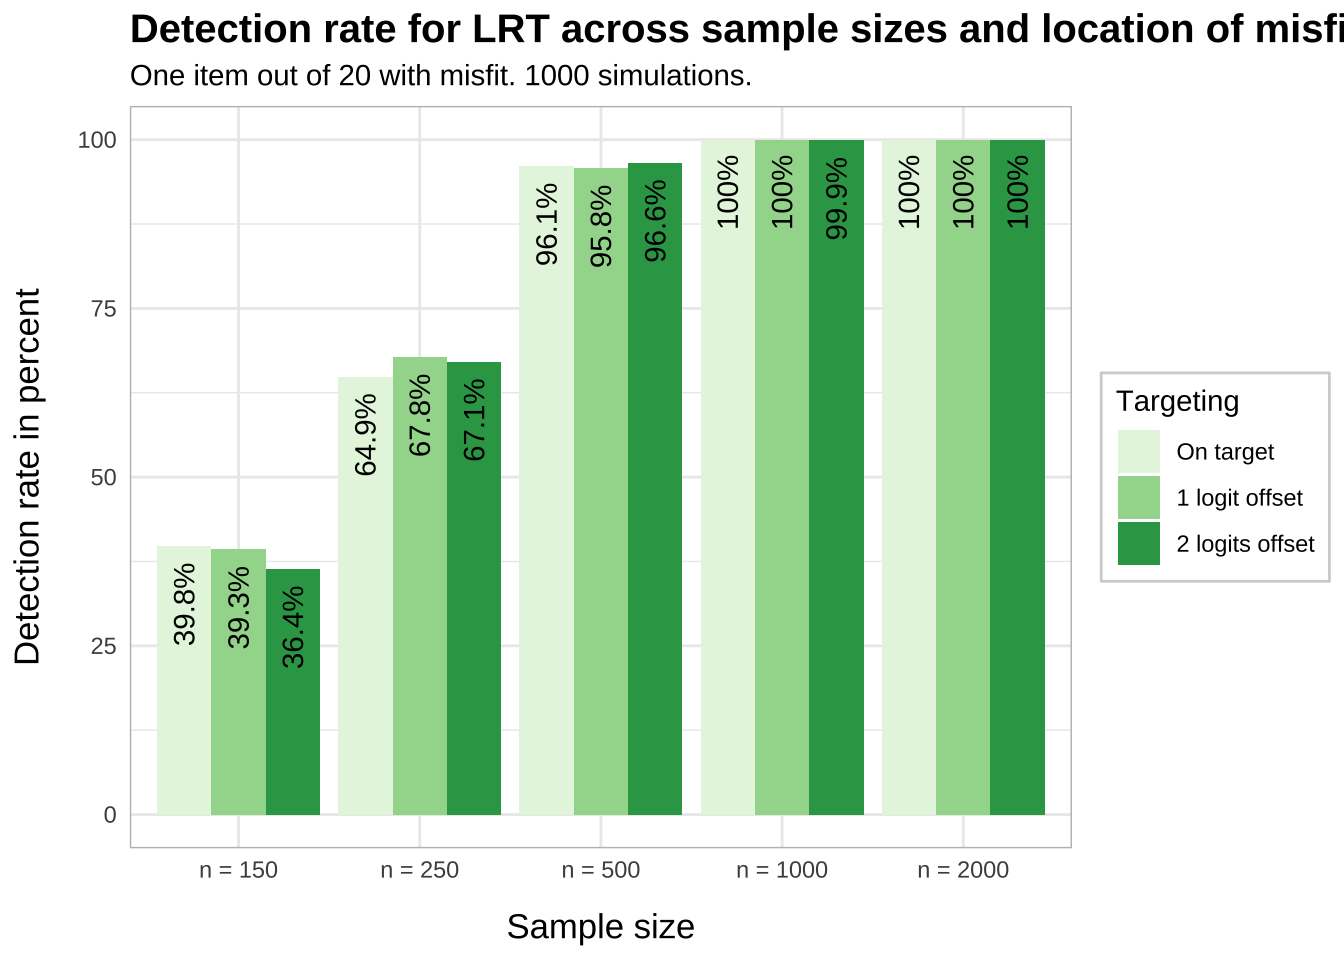
<figcaption>(a) Across sample sizes and location of misfit item</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div class="cell-output-display" width="100.0%" data-layout-align="left">
<figure id="fig-lrt1-2">
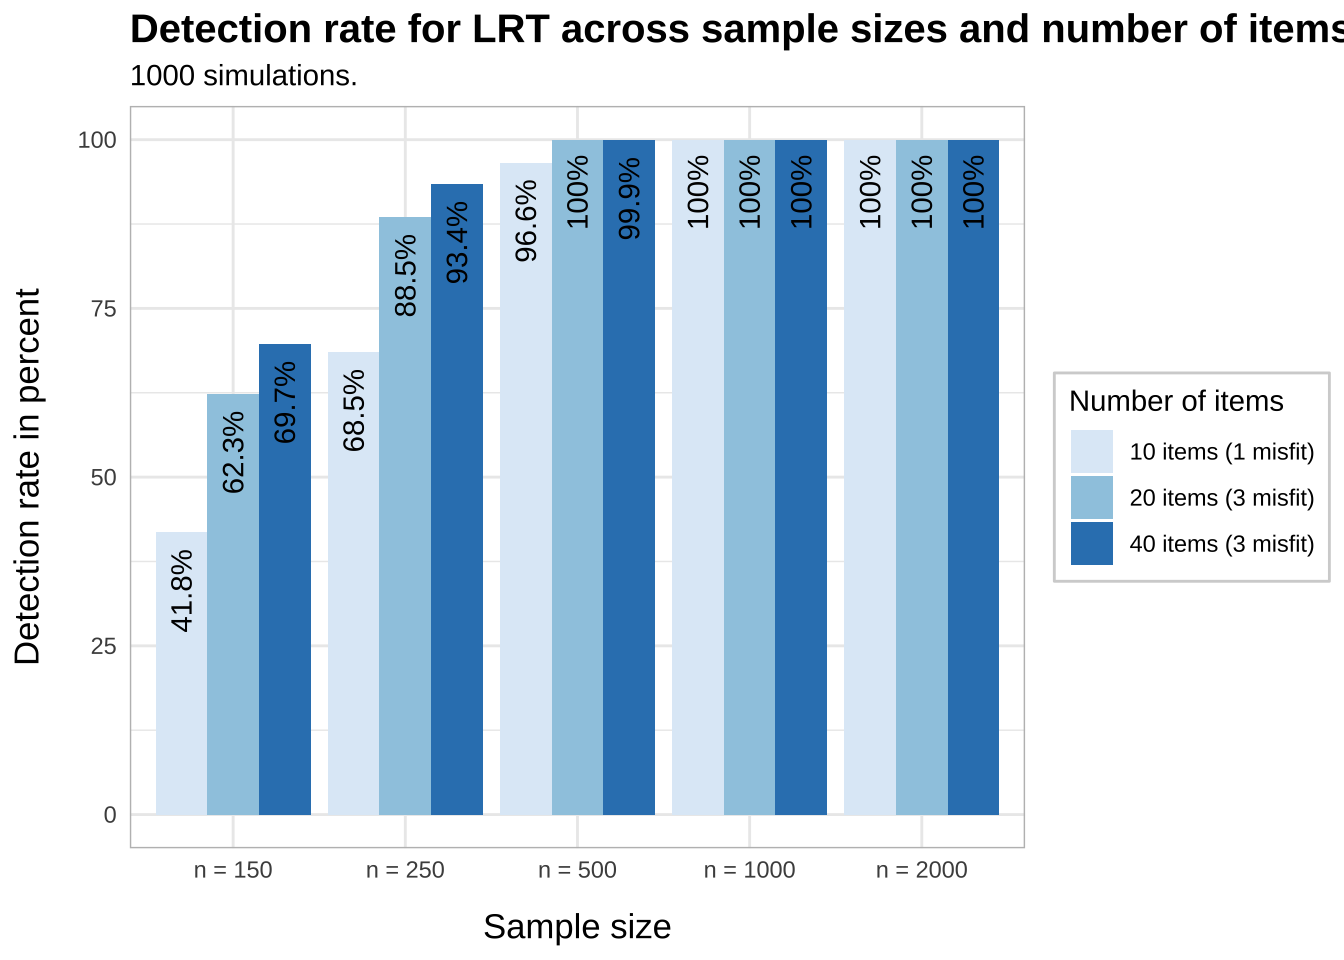
<figcaption>(b) Across sample sizes and number of items</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 22: Likelihood ratio test detection rate

Results for targeting of the misfit item are summarized in <a href="#fig-lrt1" class="quarto-xref">Figure 22</a>, where the detection rate is reported based on the proportion of p-values below .05 in each condition.

LRT performs better than item-restscore for the off-target item conditions, especially when targeting was at -2 logits. Otherwise, performance is similar. Infit is better than LRT for n \< 500 when targeting = 0, similar at targeting = 1, and LRT is better than infit at targeting -2.

Looking at LRT for different numbers of items and comparing to results for infit and item-restscore at their best detection rates for the corresponding number of items and sample size, it shows much worse performance for 10 items compared to infit and item-restscore at n = 150, but similar performance at larger sample sizes. For 20 and 40 items, LRT is similar to infit at all sample sizes, and slightly better than item-restscore for n \< 500.

# 9. Discussion

This paper was created primarily out of a desire to understand the performance of conditional item fit and item-restscore in detecting item misfit. Studies 1-3 and 5 were originally planned, while study 4 was added due to the results of previous studies showing issues with large sample sizes, and study 6 was added mostly for didactic purposes but also out of curiosity of the global fit LRT performance compared to the other methods. Müller’s ([2020](#ref-muller_item_2020)) paper on conditional item fit was published five years ago with results that should have sparked discussions in the Rasch community about updating methods (and software) and the justification of rule-of-thumb critical values. We hope that this paper can help spur such discussions by the simple methodology and presentation of results used, which could make this paper more accessible for practitioners.

Main results summarized:

-   small samples (n \< 250-500) with small numbers of items make it harder to detect misfitting items
-   small samples (n \< 250-500) should rely primarily on conditional item infit with simulation-based critical values
-   large samples (n \> 500) should use bootstrapped item-restscore to reduce the risk of falsely identifying misfit
-   misfit in an off-target item is harder to detect than well-targeted items and the LRT test can assist in identifying misfit in off-target items
-   increased number of items increases the power to detect misfit

Assessment of item fit and dimensionality should always be done using multiple methods. Study 6 showed the benefits of also looking at the likelihood ratio test when the misfitting item is located -2 logits away from the sample mean location. Previous simulation studies concluded that the LRT did not perform well at detecting multidimensionality, which is how the misfitting items were generated in this study. While no method in this study achieved very good results at the lowest sample size (n = 150), LRT did not do much worse than the other methods.

In [ ]:
RIloadLoc(simdata3[1:400,], model = "RM")

Item fit and item-restscore are recommended to be used in parallel, while also examining residual patterns by reviewing standardized factor loadings on the first residual contrast (see <a href="#fig-loadloc" class="quarto-xref">Figure 23</a> for an example using n = 400) as well as Yen’s Q3 residual correlations ([Christensen, Makransky, and Horton 2017](#ref-christensen_critical_2017)). Regarding residual correlations and critical values, the `easyRasch` package also contains a function to use bootstrapping (`RIgetResidCor()`), similar to the `RIgetfit()` function, to determine the appropriate cutoff. This is described briefly in a blog post ([Johansson 2024b](#ref-johansson_simulation_2024)) and a simulation paper is under preparation.

Item fit in this paper has been assessed using data from all individual respondents in a sample. A useful additional method to evaluate and understand item fit or misfit is to inspect item characteristic curves where the sample is divided into class intervals based on their total score ([Buchardt, Christensen, and Jensen 2023](#ref-buchardt_visualizing_2023)).

While the simulations in this paper have all used dichotomous data, all functions evaluated from the `easyRasch` package in this paper also work with polytomous data using the Rasch Partial Credit Model.

## 9.1 Limitations

The total number of items and the proportion of misfit items clearly have effects on detection rate and could have been investigated further using more variations in sample sizes. The Rasch partial credit model for polytomous data (PCM, [Masters 1982](#ref-masters_rasch_1982)) would have been useful to include in a comparison study. When testing the bootstrapped item-restscore method, more variations in the number of bootstrap samples (iterations) might have been of interest, although the difference between 250 and 500 was small.

# 10. Conclusion

For sample sizes under 500, it seems best to rely mostly on item infit with simulation-based critical values, using 100 iterations with `RIgetfit()`. For sample sizes closer to 500, item-restscore is recommended as the primary method, either as a single-run test or bootstrapped. With samples larger than 500, bootstrapped item-restscore controls false positive rates well, while showing high rates of misfit detection. Using 250 iterations for the bootstrapped item-restscore seems adequate. In general, both infit and item-restscore are useful in the analysis process if you have a sample size below 1000.

The findings reported here also make a good argument for removing one item at a time when the analysis indicates several misfitting items, starting with the most underfitting item. This is especially relevant for n \>= 500 and when misfitting items are located close to the sample mean.

# References

Andersen, Erling B. 1973. “A Goodness of Fit Test for the Rasch Model.” *Psychometrika* 38 (1): 123–40. <https://doi.org/10.1007/BF02291180>.

Benjamini, Yoav, and Yosef Hochberg. 1995. “Controlling the False Discovery Rate: A Practical and Powerful Approach to Multiple Testing.” *Journal of the Royal Statistical Society: Series B (Methodological)* 57 (1): 289–300. <https://doi.org/10.1111/j.2517-6161.1995.tb02031.x>.

Bond, Trevor, and Christine M. Fox. 2015. *Applying the Rasch Model: Fundamental Measurement in the Human Sciences*. 3rd ed. London, UNITED KINGDOM: Routledge.

Buchardt, Ann-Sophie, Karl Bang Christensen, and Normann Jensen. 2023. “Visualizing Rasch Item Fit Using Conditional Item Characteristic Curves in R.” *Psychological Test and Assessment Modeling* 65 (2): 206–19.

Chou, Yeh-Tai, and Wen-Chung Wang. 2010. “Checking Dimensionality in Item Response Models With Principal Component Analysis on Standardized Residuals.” *Educational and Psychological Measurement* 70 (5): 717–31. <https://doi.org/10.1177/0013164410379322>.

Christensen, Karl Bang, Guido Makransky, and Mike Horton. 2017. “Critical Values for Yen’s Q3: Identification of Local Dependence in the Rasch Model Using Residual Correlations.” *Applied Psychological Measurement* 41 (3): 178–94. <https://doi.org/10.1177/0146621616677520>.

Debelak, Rudolf. 2019. “An Evaluation of Overall Goodness-of-Fit Tests for the Rasch Model.” *Frontiers in Psychology* 9 (January). <https://doi.org/10.3389/fpsyg.2018.02710>.

Goodman, Leo A., and William H. Kruskal. 1954. “Measures of Association for Cross Classifications.” *Journal of the American Statistical Association* 49 (268): 732–64. <https://doi.org/10.2307/2281536>.

Johansson, Magnus. 2024a. *easyRasch: Psychometric Analysis in r with Rasch Measurement Theory*. <https://github.com/pgmj/easyRasch>.

———. 2024b. “Simulation Based Cutoff Values for Rasch Item Fit and Residual Correlations.” *R, Rasch, Etc*. <https://pgmj.github.io/simcutoffs.html>.

Kreiner, Svend. 2011. “A Note on Item–Restscore Association in Rasch Models.” *Applied Psychological Measurement* 35 (7): 557–61. <https://doi.org/10.1177/0146621611410227>.

Mair, Patrick, and Reinhold Hatzinger. 2007. “Extended Rasch Modeling: The <span class="nocase">eRm</span> Package for the Application of IRT Models in R.” *Journal of Statistical Software* 20 (1): 1–20. <https://doi.org/10.18637/jss.v020.i09>.

Masters, Geoff N. 1982. “A Rasch Model for Partial Credit Scoring.” *Psychometrika* 47 (2): 149–74. <https://doi.org/10.1007/BF02296272>.

McNeish, Daniel, and Melissa G. Wolf. 2024. “Direct Discrepancy Dynamic Fit Index Cutoffs for Arbitrary Covariance Structure Models.” *Structural Equation Modeling: A Multidisciplinary Journal* 31 (5): 835–62. <https://doi.org/10.1080/10705511.2024.2308005>.

Mueller, Marianne, and Pedro Henrique Ribeiro Santiago. 2022. “Iarm: Item Analysis in Rasch Models.” <https://cran.r-project.org/web/packages/iarm/index.html>.

Müller, Marianne. 2020. “Item Fit Statistics for Rasch Analysis: Can We Trust Them?” *Journal of Statistical Distributions and Applications* 7 (1): 5. <https://doi.org/10.1186/s40488-020-00108-7>.

Ostini, Remo, and Michael Nering. 2006. *Polytomous Item Response Theory Models*. SAGE Publications, Inc. <https://doi.org/10.4135/9781412985413>.

Smith, Everett V. 2002. “[Detecting and Evaluating the Impact of Multidimensionality Using Item Fit Statistics and Principal Component Analysis of Residuals](https://www.ncbi.nlm.nih.gov/pubmed/12011501).” *Journal of Applied Measurement* 3 (2): 205–31.

Smith, R. M., R. E. Schumacker, and M. J. Bush. 1998. “[Using Item Mean Squares to Evaluate Fit to the Rasch Model](https://www.ncbi.nlm.nih.gov/pubmed/9661732).” *Journal of Outcome Measurement* 2 (1): 66–78.

Warm, Thomas A. 1989. “Weighted Likelihood Estimation of Ability in Item Response Theory.” *Psychometrika* 54 (3): 427–50. <https://doi.org/10.1007/BF02294627>.

# 11. Additional materials

-   GitHub link for `easyRasch` source code: <https://github.com/pgmj/easyRasch/>
    -   Most functions are defined in this file: <https://github.com/pgmj/easyRasch/blob/main/R/easyRasch.R>

## 11.1 Session info

This documents the specific R packages and versions used in this study. Note that the simulations were conducted using `easyRasch` version 0.3.3, while the plots and tables generated directly from `easyRasch` were done using version 0.3.3.2.

In [ ]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: Europe/Stockholm
tzcode source: internal

attached base packages:
 [1] parallel  grid      stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] showtext_0.9-7    showtextdb_3.0    sysfonts_0.8.9    arrow_16.1.0     
 [5] easyRasch_0.3.3.2 doParallel_1.0.17 iterators_1.0.14  furrr_0.3.1      
 [9] future_1.34.0     foreach_1.5.2     janitor_2.2.0     hexbin_1.28.4    
[13] catR_3.17         glue_1.8.0        ggrepel_0.9.6     patchwork_1.3.0  
[17] reshape_0.8.9     matrixStats_1.4.1 psychotree_0.16-1 psychotools_0.7-4